<a href="https://colab.research.google.com/github/bgorai005/deeplearning_assignment1/blob/main/dl_assign1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Name-Biswajit gorai ,Roll no- MA24M005

In [3]:
# Q1: loading the Mnist Fashion dataset
import numpy as np
from keras.datasets import fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


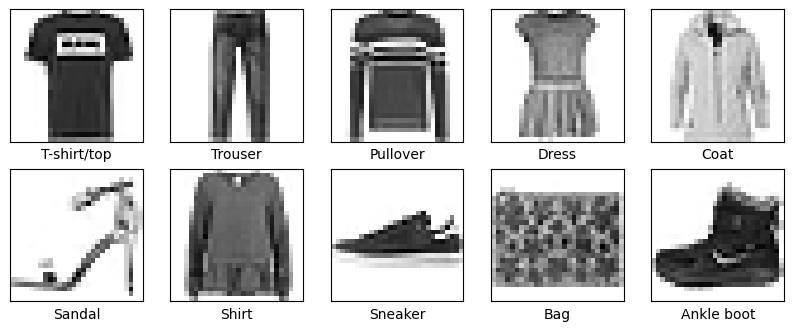

In [4]:
#define the class labels
class_labels = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

#plot the image of each class
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for labels in range(10):
    plt.subplot(5, 5, labels + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.xlabel(class_labels[labels])
    plt.imshow(train_images[train_labels == labels][0], cmap=plt.cm.binary)
plt.show()

In [5]:
#flattenten the image data
train_images = train_images.reshape((train_images.shape[0], -1))
test_images = test_images.reshape((test_images.shape[0], -1))

In [6]:
#normalize the image data
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [7]:
#apply one hot encoding in output column
def one_hot_encoding(labels,num_classes):
  one_hot_labels=np.zeros((len(labels),num_classes))
  for i,label in enumerate(labels):
    one_hot_labels[i][label]=1
  return one_hot_labels

In [15]:
import numpy as np
# create a feedforward neural network
class FeedForwardNeuralNetwork:
  def __init__(self,input_size,num_layers=1,hidden_size=4,output_size=1,weight_int='random'):
    self.input_size=input_size
    self.num_layers=num_layers
    self.hidden_size=hidden_size
    self.output_size=output_size
    self.weight_int = weight_int
    self.weights = self.initialize_weights()

  def initialize_weights(self):
    network_size=[]
    for i in range(self.num_layers):
      network_size.append(self.hidden_size)
    network_size=[self.input_size]+network_size+[self.output_size]
    weights={}
    for i in range(1,self.num_layers+2):
     if self.weight_int=='random':
      weights[f'w{i}']=np.random.randn(network_size[i],network_size[i-1])
      weights[f'b{i}']=np.random.randn(network_size[i],1)
     elif self.weight_int=='xavier':
      weights[f'w{i}']=np.random.rand(network_size[i],network_size[i-1])*np.sqrt(2/network_size[i-1])
      weights[f'b{i}']=np.random.rand(network_size[i],1)*np.sqrt( 2/network_size[i-1])

    return weights


  def sigmoid(self,x):
    return 1/(1+np.exp(-x))


  def softmax(self,x):
    x=x-np.max(x)
    return np.exp(x)/np.sum(np.exp(x))


  def forward_prop(self,x):
    a={}
    h={'h0':x}

    for i in range(1,self.hidden_size+1):
      a[f'a{i}']=np.dot(self.weights[f'w{i}'],h[f'h{i-1}'])+self.weights[f'b{i}']
      h[f'h{i}']=self.sigmoid(a[f'a{i}'])
    a[f'a{self.hidden_size+1}']=np.dot(self.weights[f'w{self.hidden_size+1}',h[f'h{self.hidden_size}']])  +self.weights[f'b{self.hidden_size+1}']
    y_pred=self.softmax(a[f'a{self.hidden_size+1}'])
    return a,h,y_pred

  def back_prop(self,x,y_actual,theta,input_size):
    m=x.shape[0]
    a,h,y_pred=self.forward_prop(x,theta,self.num_layers,self.input_size)
    grad_theta={}
    grad_h_a={}
    grad_h_a[f'a{self.num_layers+1}']=-1*(y_actual-y_pred)
    for i in range(self.num_layers+1,0,-1):
      grad_theta[f'w{i}']=np.dot(grad_h_a[f'a{i}'],h[f'h{i-1}'].T)*(1/m)
      grad_theta[f'b{i}']=np.mean(grad_h_a[f'a{i}'],axis=1,keepdims=True)*(1/m)
      grad_h_a[f'h{i-1}']=np.dot(self.weights[f'w{i}'].T,grad_h_a[f'a{i}'])
      grad_h_a[f'a{i-1}']=grad_h_a[f'h{i-1}']*(self.der_sigmoid(h[f'h{i-1}']))
    return grad_theta




firstnetwork=FeedForwardNeuralNetwork(input_size=784,num_layers=3,hidden_size=32,output_size=10,weight_int='random')
print(firstnetwork.weights.keys())


dict_keys(['w1', 'b1', 'w2', 'b2', 'w3', 'b3', 'w4', 'b4'])
